1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import imshow
from scipy import optimize
from scipy.optimize import minimize
import math
import pickle
import pandas as pd

Global minimum: [ 0.08984201 -0.71265642] with value: -1.031628453489876 with initial guess [-0.5, -0.5]
Global minimum: [-1.60710546 -0.56865202] with value: 2.1042503103152153 with initial guess [-1.5, -1.5]
Global minimum: [0. 0.] with value: 0.0 with initial guess [0, 0]


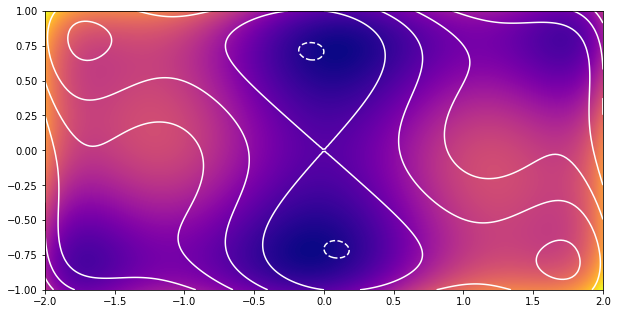

In [2]:

def fun(x):
    return (4*pow(x[0],2)-2.1*pow(x[0],4)+pow(x[0],6)/3+x[0]*x[1]+4*pow(x[1],4)-4*pow(x[1],2))

x = np.linspace(-2, 2, 200)
y = np.linspace(-1, 1, 200)


X, Y = np.meshgrid(x, y)
Z = fun([X, Y])

fig = plt.figure(figsize=(10,10))

plt.imshow(fun([X, Y]), cmap=plt.cm.plasma, interpolation='bilinear',extent = [-2, 2, -1, 1])
plt.contour(X, Y, Z, colors='white')

x0=[-0.5,-0.5]
min1 = minimize(fun,x0)
print("Global minimum: {} with value: {} with initial guess {}".format(min1['x'], min1['fun'], x0))

x0=[-1.5,-1.5]
min2 = minimize(fun,x0)
print("Global minimum: {} with value: {} with initial guess {}".format(min2['x'],min2['fun'], x0))

x0=[0,0]
min3 = minimize(fun,x0)
print("Global minimum: {} with value: {} with initial guess {}".format(min3['x'],min3['fun'], x0))







2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

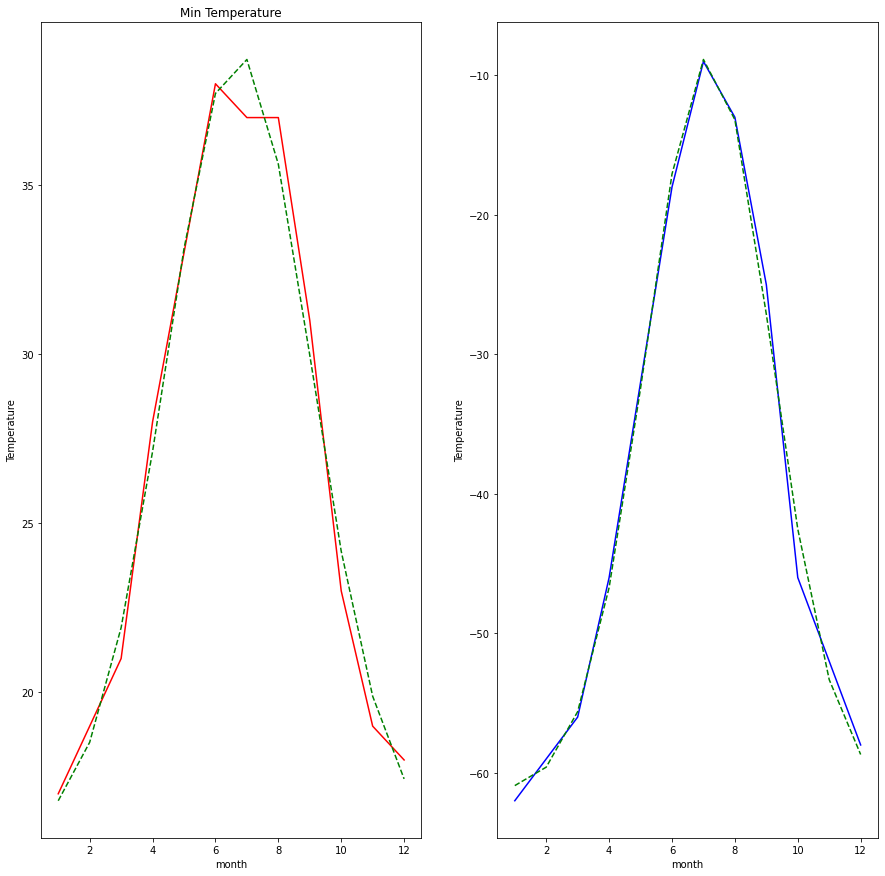

In [3]:
temp_max=[ 17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
temp_min=[-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

session = np.arange(1,13)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.plot(session ,temp_max , color='red')
ax2.plot(session, temp_min , color='blue')

ax1.set_title("Max Temperature")
ax1.set_ylabel('Temperature')
ax1.set_xlabel('month')

ax1.set_title("Min Temperature")
ax2.set_ylabel('Temperature')
ax2.set_xlabel('month')


def f_gaussian (x,a, m, std, offset):
    return a*np.exp(-(x-m)**2/(2*std**2))-offset
        

res_max, cov_max = optimize.curve_fit(f_gaussian, session, temp_max )
res_min, cov_min = optimize.curve_fit(f_gaussian, session, temp_min)

ax1.plot(session, f_gaussian(session, *res_max), 'g--')
ax2.plot(session, f_gaussian(session, *res_min), 'g--')


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [4]:
with open('data/residuals_261.pkl', 'rb') as f_residual:
    data = pickle.load(f_residual)

df = pd.DataFrame(data.item())

df


,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


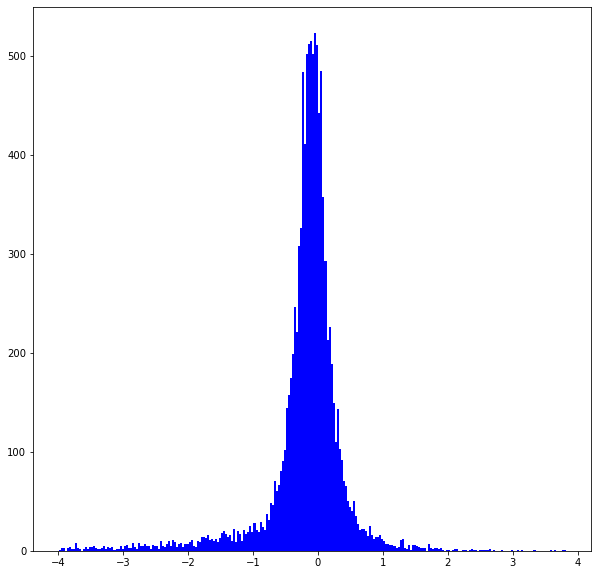

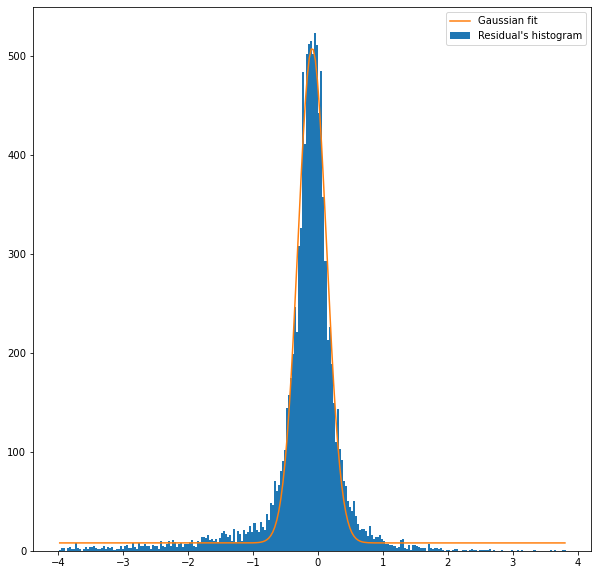

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
h, bins, _ = plt.hist(df['residuals'], bins=250, color='blue')


df = df[df['residuals'] > -4]
df = df[df['residuals'] < 4]

centers = 0.5 * (bins[:-1] + bins[1:])

res, cov = optimize.curve_fit(f_gaussian, centers, h, full_output=False)

fig, ax = plt.subplots(figsize=(10, 10))

plt.hist(df['residuals'], bins=250, label='Residual\'s histogram')
plt.plot(centers, f_gaussian(centers, *res), label='Gaussian fit')
ax.legend()

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

Best fit parameters for f(x):
 amplitude: -9.671276806512251 	shift: 12.342717347970158 	traslation: 9.052562102733884

Best fit parameters for g(x):
 amplitude: -9.671613809442105 	shift: 0.9997396562248598 	traslation: 15.621292454639965

Overal average temperature in Munich is  8.9 celsius

Daily average prediction of year by f(x):
Coldest time of year: -0.6  celsius
Hottest time of year: 18.7  celsius

Daily average prediction of year by g(x):
Coldest time of year: -0.6  celsius
Hottest time of year: 18.7  celsius

RSS of function f(x) is 694209.8326248894 and RSS of function g(x) is 694186.2523476013.

Additional parameter is not needed since CL = 0.633917997505955 .


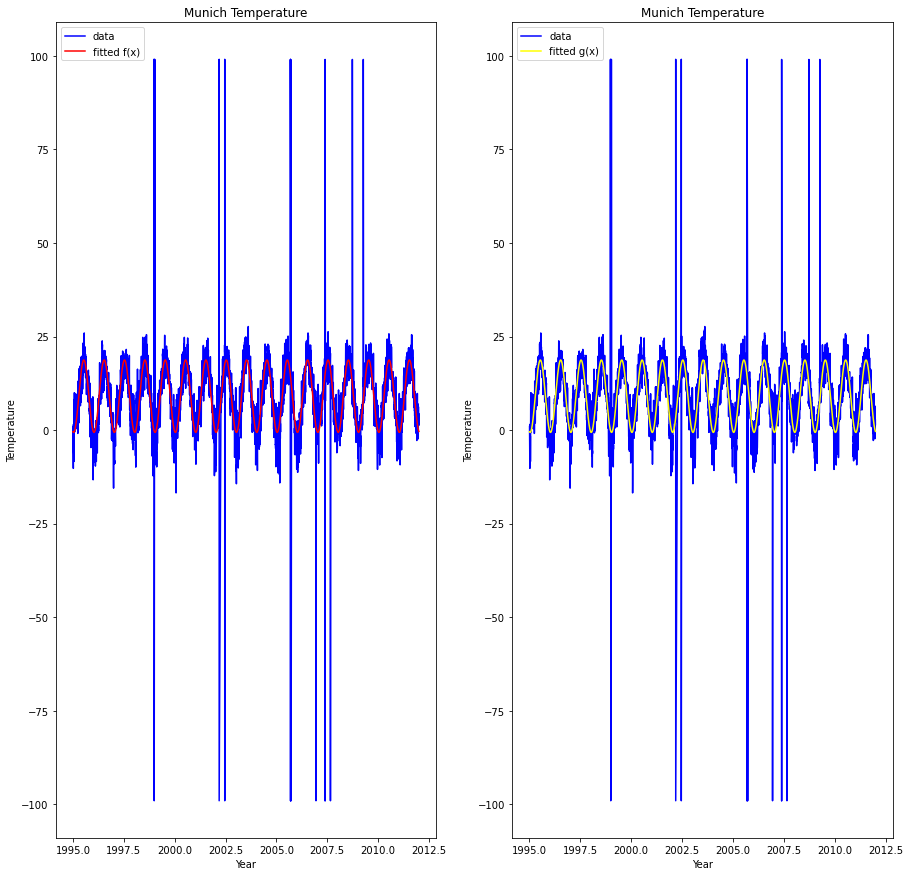

In [6]:
mt = pd.read_csv('data/munich_temperatures_average_with_bad_data.txt', sep=" ", header=None)
mt.columns = ["Year", "Temperature"]
mt


def f(x, a, b,c):
    return a * np.cos(2*math.pi*x + b) + c

def g(x, a, b,c,d):
    return a * np.cos(2*math.pi*x*b + c) + d



optf, covf = optimize.curve_fit(f, mt['Year'], mt['Temperature'], full_output=False)
optg, covg = optimize.curve_fit(g,  mt['Year'], mt['Temperature'],full_output=False)

mtp = mt[mt['Year']>2008]
mtp = mt[mt['Year']<2012]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.plot(mtp['Year'], mtp['Temperature'], label = 'data', color = 'blue')
ax1.plot(mtp['Year'], f(mtp['Year'], *optf), label='fitted f(x)', color = 'red')

ax2.plot(mtp['Year'], mtp['Temperature'], label = 'data', color = 'blue')
ax2.plot(mtp['Year'], g(mtp['Year'], *optg), label='fitted g(x)', color = 'yellow')

ax1.set_title("Munich Temperature")
ax1.set_ylabel('Temperature')
ax1.set_xlabel('Year')
ax1.legend()

ax2.set_title("Munich Temperature")
ax2.set_ylabel('Temperature')
ax2.set_xlabel('Year')
ax2.legend()



print("Best fit parameters for f(x):\n", "amplitude:", optf[0],"\tshift:" ,optf[1], "\ttraslation:",optf[2])
print("\nBest fit parameters for g(x):\n", "amplitude:", optg[0],"\tshift:" ,optg[1], "\ttraslation:",optg[2])

print("\nOveral average temperature in Munich is ", round(mt['Temperature'].mean(),1), "celsius")

print('\nDaily average prediction of year by f(x):')
print('Coldest time of year:',round(f(mt['Year'], *optf).min(),1),' celsius')
print('Hottest time of year:',round(f(mt['Year'], *optf).max(),1),' celsius')

print('\nDaily average prediction of year by g(x):')
print('Coldest time of year:',round(g(mt['Year'], *optg).min(),1),' celsius')
print('Hottest time of year:',round(g(mt['Year'], *optg).max(),1),' celsius')

res_f = f(mt['Year'],*optf) - mt['Temperature']
res_g = g(mt['Year'],*optg) - mt['Temperature']

RSS_f = np.sum(res_f**2)
RSS_g = np.sum(res_g**2)
print('\nRSS of function f(x) is {} and RSS of function g(x) is {}.'.format(RSS_f,RSS_g))


from scipy.stats import f

# define function for F-test
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL


N = len(mt['Year'])

y1 = f(mt['Year'], *optf)
y2 = g(mt['Year'], *optg)

CL = Ftest(RSS_f, RSS_g, 1, 2, N, verbose=False)

if CL < 0.1:
    print ('\nAdditional parameter is needed since CL =',CL,'.')
else:
    print('\nAdditional parameter is not needed since CL =',CL,'.')